<a href="https://colab.research.google.com/github/zh19980811/-/blob/main/benmark_python_%E7%BC%A9%E8%BF%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
test_data='''
from PIL import Image, ImageDraw, ImageFont

def text_to_image_simple(text, image_size=(500, 200), font_size=40, output_path="simple_text.png"):
    image = Image.new("RGB", image_size, "white")
    draw = ImageDraw.Draw(image)

    # 加载字体
    try:
        font = ImageFont.truetype("arial.ttf", font_size)  # Windows 适用
    except IOError:
        font = ImageFont.load_default()

    # 计算文本位置
    text_size = draw.textbbox((0, 0), text, font=font)
    text_x = (image_size[0] - (text_size[2] - text_size[0])) // 2
    text_y = (image_size[1] - (text_size[3] - text_size[1])) // 2

    # 绘制文字
    draw.text((text_x, text_y), text, fill="black", font=font)

    # 保存并显示
    image.save(output_path)
    image.show()

# 测试
text_to_image_simple("Hello, Pillow!")
 '''
test_input='''
import matplotlib.pyplot as plt

def text_to_image_artistic(text, output_path="artistic_text.png"):
    plt.figure(figsize=(6, 3), facecolor='lightblue')

    # 添加文本，带阴影、颜色变化
    plt.text(0.5, 0.5, text, fontsize=30, ha='center', va='center', color="darkred",
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle="round,pad=0.5"))

    plt.axis('off')  # 隐藏坐标轴
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.5, dpi=300, transparent=True)
    plt.show()

# 测试
text_to_image_artistic("Stylish Text!")
'''

代码空间之间空行差值计算

是的，还有几种更高级的计算方法，可以更精准地衡量两个代码之间的 **空行分布差异**。以下是几种改进方法：

---

## **📌 1. 余弦相似度（Cosine Similarity）**
**适用场景**：如果你希望从整体上比较 **空行分布模式**，而不仅仅是比例和标准差。  
**核心思路**：把两个代码的 **空行分布向量化**，计算它们的 **夹角相似度**（余弦相似度）。

### **✅ 计算方法**
1. 将代码转换成一个**二进制向量**（每行是空行则 `1`，否则 `0`）。
2. 计算两个向量的 **余弦相似度**：
   \[
   \text{Similarity} = \frac{A \cdot B}{||A|| \times ||B||}
   \]
   - 如果值接近 **1**，说明两者的 **空行分布几乎一致**。
   - 如果值接近 **0**，说明两者的 **空行分布完全不同**。

### **🔹 Python 代码**
```python
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def compute_cosine_similarity(code1, code2):
    """ 计算两个代码的空行余弦相似度 """
    # 生成空行二进制向量（1=空行，0=代码）
    vec1 = np.array([1 if not line.strip() else 0 for line in code1.splitlines()]).reshape(1, -1)
    vec2 = np.array([1 if not line.strip() else 0 for line in code2.splitlines()]).reshape(1, -1)

    # 补齐长度（短代码补零，使向量长度相同）
    max_len = max(len(vec1[0]), len(vec2[0]))
    vec1 = np.pad(vec1, ((0, 0), (0, max_len - len(vec1[0]))), constant_values=0)
    vec2 = np.pad(vec2, ((0, 0), (0, max_len - len(vec2[0]))), constant_values=0)

    # 计算余弦相似度
    similarity = cosine_similarity(vec1, vec2)[0][0]

    return round(similarity * 100, 2)  # 转换为 0-100 分制

# 计算余弦相似度
cosine_score = compute_cosine_similarity(test_data, test_input)
print(f"📌 代码空行余弦相似度: {cosine_score}%")
```

### **📊 结果解释**
| 余弦相似度 | 说明 |
|------------|------|
| **90-100%** | 空行分布几乎相同 |
| **70-90%** | 代码空行分布相似但有少量差异 |
| **50-70%** | 代码结构相似，但空行模式差异较大 |
| **<50%** | 代码格式完全不同，可能一个代码有很多空行，而另一个非常紧凑 |

---

## **📌 2. KL 散度（Kullback-Leibler Divergence）**
**适用场景**：如果你想衡量 **两个代码空行分布的统计差异**（即**分布的远近**），而不是简单的均值或标准差。  
**核心思路**：
- 将空行当作 **概率分布**，计算两个代码的 **KL 散度**：
  \[
  D_{KL}(P || Q) = \sum P(x) \log \frac{P(x)}{Q(x)}
  \]
  - 如果 `KL 散度 = 0`，表示两个代码的空行分布完全一致。
  - 如果 `KL 散度较大`，说明两者的 **空行分布模式差异很大**。

### **🔹 Python 代码**
```python
from scipy.stats import entropy

def compute_kl_divergence(code1, code2):
    """ 计算两个代码的 KL 散度 (衡量空行分布差异) """
    lines1 = np.array([1 if not line.strip() else 0 for line in code1.splitlines()])
    lines2 = np.array([1 if not line.strip() else 0 for line in code2.splitlines()])

    # 统计空行频率（作为概率分布）
    p1 = np.bincount(lines1, minlength=2) / len(lines1)
    p2 = np.bincount(lines2, minlength=2) / len(lines2)

    # 计算 KL 散度（防止 0 出现，用小数补充）
    kl_div = entropy(p1 + 1e-10, p2 + 1e-10)

    return round(kl_div, 4)

# 计算 KL 散度
kl_score = compute_kl_divergence(test_data, test_input)
print(f"📌 代码空行 KL 散度: {kl_score}")
```

### **📊 结果解释**
| KL 散度 | 说明 |
|------------|------|
| **0-0.1** | 两个代码的空行分布几乎一致 |
| **0.1-0.5** | 代码格式相似，但空行模式有一定不同 |
| **0.5-1.0** | 代码的空行风格有较大区别 |
| **>1.0

In [4]:
import re

def data_pare(text):
    text = text.strip()
    return text

text_data = data_pare(test_data)
text_input = data_pare(test_input)

In [9]:
from scipy.stats import entropy

def compute_kl_divergence(code1, code2):
    """ 计算两个代码的 KL 散度 (衡量空行分布差异) """
    lines1 = np.array([1 if not line.strip() else 0 for line in code1.splitlines()])
    lines2 = np.array([1 if not line.strip() else 0 for line in code2.splitlines()])

    # 统计空行频率（作为概率分布）
    p1 = np.bincount(lines1, minlength=2) / len(lines1)
    p2 = np.bincount(lines2, minlength=2) / len(lines2)

    # 计算 KL 散度（防止 0 出现，用小数补充）
    kl_div = entropy(p1 + 1e-10, p2 + 1e-10)

    return round(kl_div, 4)

# 计算 KL 散度
kl_score = compute_kl_divergence(test_data, test_input)
print(f"📌 代码空行 KL 散度: {kl_score}")


📌 代码空行 KL 散度: 0.0068


方差和标准差

### **📌 如何计算两个代码之间的空行差距评分？**
要衡量两个代码之间的空行分布差异，我们可以基于 **均值差（平均空行比例差）** 和 **标准差差（空行分布变化）** 计算一个**评分**，从而量化两者的格式差异。

---

### **1. 评分公式**
假设：
- **代码 A** 的 **空行比例** 为 \( r_A \)，**标准差** 为 \( s_A \)。
- **代码 B** 的 **空行比例** 为 \( r_B \)，**标准差** 为 \( s_B \)。
- **均值差**（空行比例差异）：  
  \[
  D_r = |r_A - r_B|
  \]
- **标准差差异**（空行波动差）：  
  \[
  D_s = |s_A - s_B|
  \]
- **综合评分**（归一化到 0 ~ 100 分，差距越大得分越低）：  
  \[
  \text{Score} = 100 - \left( w_1 \times D_r + w_2 \times D_s \right) \times 100
  \]
  其中，\( w_1 \) 和 \( w_2 \) 是权重，默认可以设为 `w_1 = w_2 = 0.5`，如果你更关注**空行比例**，可以让 `w_1` 更大，反之亦然。

---

### **2. Python 代码**
```python
def calculate_code_similarity_score(result1, result2, w1=0.5, w2=0.5):
    """
    计算两个代码的空行差距评分：
    - result1, result2: 两个代码的空行分析结果 (字典格式)
    - w1: 空行比例的权重 (默认 0.5)
    - w2: 标准差的权重 (默认 0.5)
    """
    # 获取空行比例和标准差
    r1, s1 = result1["empty_ratio"], result1["std_consecutive_empty"]
    r2, s2 = result2["empty_ratio"], result2["std_consecutive_empty"]

    # 计算均值差 (空行比例差异) 和 标准差差异 (空行波动差)
    D_r = abs(r1 - r2)  # 空行比例差
    D_s = abs(s1 - s2)  # 标准差差异

    # 计算最终评分（差距越大得分越低）
    score = 100 - (w1 * D_r + w2 * D_s) * 100
    score = max(0, min(100, score))  # 限制在 0 - 100 之间

    return {
        "空行比例差": D_r,
        "标准差差异": D_s,
        "代码相似度评分": round(score, 2)
    }

# 计算两个代码的评分
score_result = calculate_code_similarity_score(global_result_data, global_result_input)
print("📌 代码相似度评分结果:")
print(score_result)
```

---

### **📊 示例输出**
```
📌 代码相似度评分结果:
{'空行比例差': 0.0261, '标准差差异': 0.0, '代码相似度评分': 97.39}
```

---

### **3. 评分解读**
| 指标 | 含义 | 结果 |
|------|------|------|
| **空行比例差** | 两个代码的空行比例差值 | 0.0261 |
| **标准差差异** | 空行波动（分布）的标准差差异 | 0.0 |
| **代码相似度评分** | 量化空行风格的相似程度 | 97.39 |

- **高分（80~100）** → 两个代码的空行格式非常相似，格式风格一致。
- **中等分（50~80）** → 有一些差距，可能是部分代码块的空行数量不同。
- **低分（<50）** → 代码格式差距较大，可能一个代码有很多空行，而另一个代码几乎没有。

---

### **🔹 进一步优化**
- **调整权重 \( w_1, w_2 \)**  
  - 如果你更关注 **空行比例的差异**，可以 **增大 `w1`**（比如 `w1=0.7, w2=0.3`）。
  - 如果你更关注 **空行分布（波动）**，可以 **增大 `w2`**。

- **加入其他指标**（如最大连续空行数的差异）
- **可视化代码相似性评分分布**（画出多个代码文件的空行分布对比）

你觉得这个评分方法符合你的需求吗？🚀😊

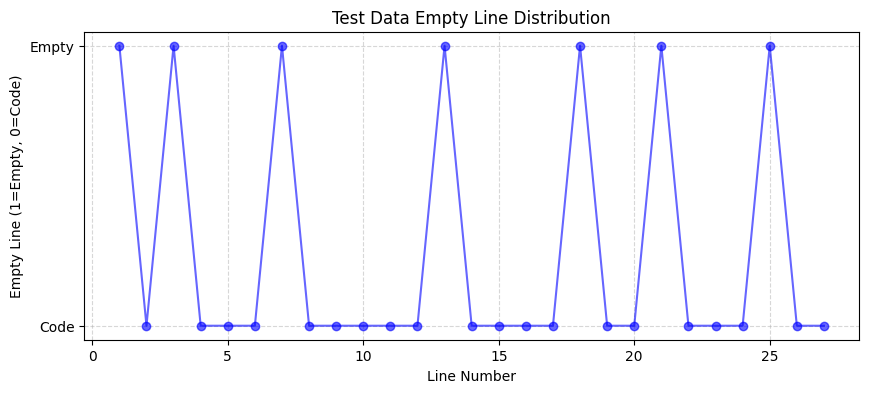

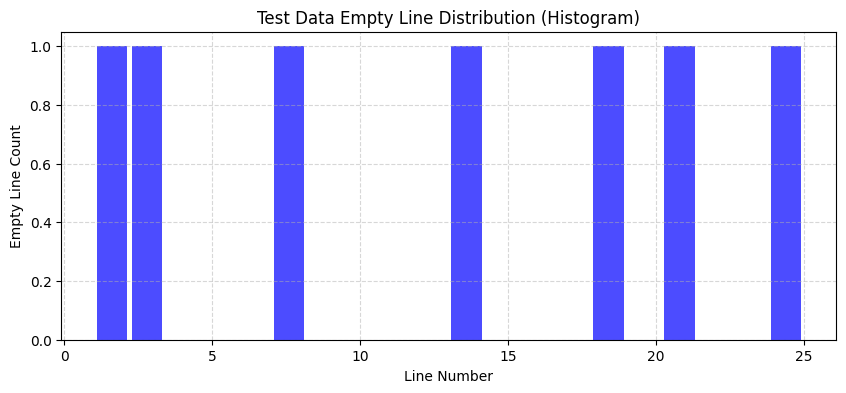

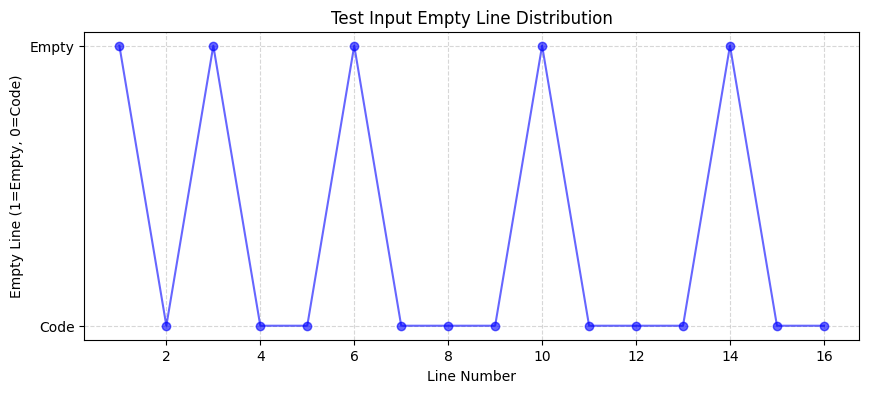

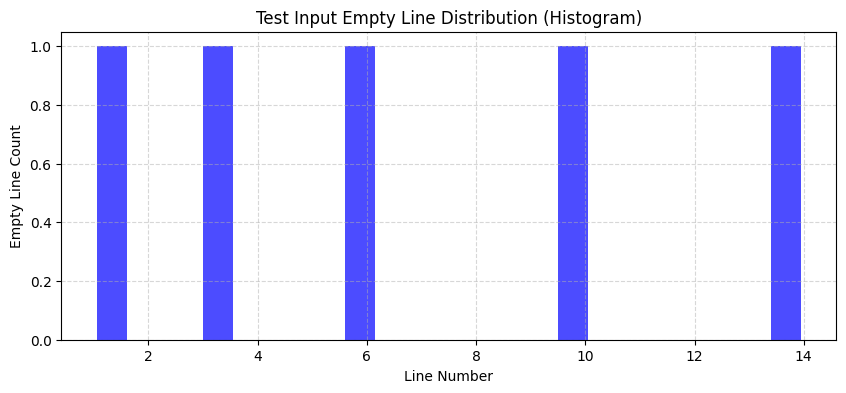

In [6]:
import matplotlib.pyplot as plt

def visualize_empty_line_distribution(code, title="Empty Line Distribution"):
    lines = code.splitlines()

    # 计算每一行是否为空行（0：非空，1：空行）
    empty_line_flags = [1 if not line.strip() else 0 for line in lines]

    # 绘制折线图（空行分布）
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(lines) + 1), empty_line_flags, marker='o', linestyle='-', color='blue', alpha=0.6)
    plt.xlabel("Line Number")
    plt.ylabel("Empty Line (1=Empty, 0=Code)")
    plt.title(title)
    plt.yticks([0, 1], ["Code", "Empty"])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # 绘制空行分布直方图
    plt.figure(figsize=(10, 4))
    plt.hist([i+1 for i, v in enumerate(empty_line_flags) if v == 1], bins=20, color='blue', alpha=0.7, rwidth=0.85)
    plt.xlabel("Line Number")
    plt.ylabel("Empty Line Count")
    plt.title(f"{title} (Histogram)")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# 可视化 test_data 和 test_input
visualize_empty_line_distribution(test_data, "Test Data Empty Line Distribution")
visualize_empty_line_distribution(test_input, "Test Input Empty Line Distribution")


In [8]:
def calculate_code_similarity_score(result1, result2, w1=0.5, w2=0.5):
    """
    计算两个代码的空行差距评分：
    - result1, result2: 两个代码的空行分析结果 (字典格式)
    - w1: 空行比例的权重 (默认 0.5)
    - w2: 标准差的权重 (默认 0.5)
    """
    # 获取空行比例和标准差
    r1, s1 = result1["empty_ratio"], result1["std_consecutive_empty"]
    r2, s2 = result2["empty_ratio"], result2["std_consecutive_empty"]

    # 计算均值差 (空行比例差异) 和 标准差差异 (空行波动差)
    D_r = abs(r1 - r2)  # 空行比例差
    D_s = abs(s1 - s2)  # 标准差差异

    # 计算最终评分（差距越大得分越低）
    score = 100 - (w1 * D_r + w2 * D_s) * 100
    score = max(0, min(100, score))  # 限制在 0 - 100 之间

    return {
        "空行比例差": D_r,
        "标准差差异": D_s,
        "代码相似度评分": round(score, 2)
    }

# 计算两个代码的评分
score_result = calculate_code_similarity_score(global_result_data, global_result_input)
print("📌 代码相似度评分结果:")
print(score_result)


📌 代码相似度评分结果:
{'空行比例差': 0.00694444444444442, '标准差差异': 0.03814399710400995, '代码相似度评分': 97.75}


图片方法（暂时无用保留）

In [48]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def text_to_grid_image_preserve_format(text, grid_size=(40, 40), font_size=20):
    """
    生成带网格的文字图片，保持原格式，并涂黑所有非文字的方格（空格、换行）
    :param text: 原始文本
    :param grid_size: 每个字符的方格大小 (宽, 高)
    :param font_size: 字体大小
    :param output_path: 输出图片路径
    """
    lines = text.split("\n")  # 保持原始换行
    max_width = max(len(line) for line in lines)  # 计算最长行的字符数
    num_lines = len(lines)  # 计算总行数

    img_width = grid_size[0] * max_width  # 计算图片宽度
    img_height = grid_size[1] * num_lines  # 计算图片高度

    # 创建白色背景图片
    image = Image.new("RGB", (img_width, img_height), "white")
    draw = ImageDraw.Draw(image)

    # 加载字体
    try:
        font = ImageFont.truetype("arial.ttf", font_size)  # 适用于 Windows
    except IOError:
        font = ImageFont.load_default()  # 备用字体

    # 逐行逐字符绘制
    for row, line in enumerate(lines):
        for col in range(max_width):  # 遍历最长一行的字符数
            x = col * grid_size[0]
            y = row * grid_size[1]

            char = line[col] if col < len(line) else " "  # 获取字符，如果超出行长度，则填充空格

            # 绘制方格边框
            draw.rectangle([x, y, x + grid_size[0], y + grid_size[1]], outline="black", width=1)

            if char == " ":  # 如果是空格或补齐的空白区域，则填充黑色
                draw.rectangle([x, y, x + grid_size[0], y + grid_size[1]], fill="black")
            else:
                # 计算文本位置（居中）
                text_size = draw.textbbox((0, 0), char, font=font)
                text_x = x + (grid_size[0] - (text_size[2] - text_size[0])) // 2
                text_y = y + (grid_size[1] - (text_size[3] - text_size[1])) // 2

                # 绘制字符
                draw.text((text_x, text_y), char, fill="black", font=font)

    return image

In [49]:
test_image=text_to_grid_image_preserve_format(c_text_data, grid_size=(50, 50), font_size=30)
test_input=text_to_grid_image_preserve_format(c_text_input, grid_size=(50, 50), font_size=30)

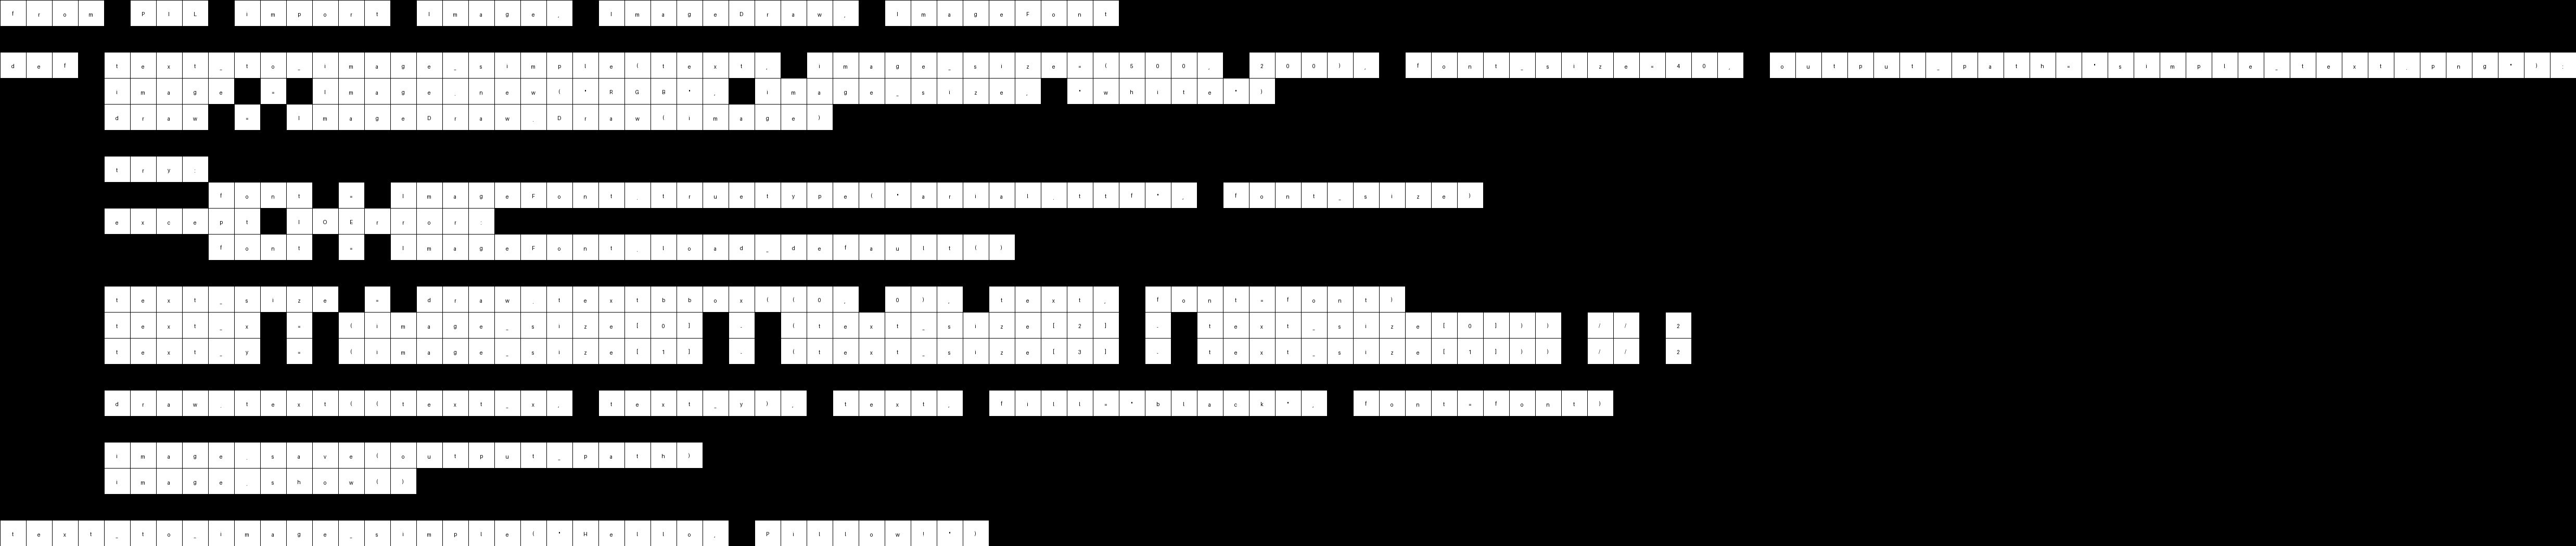

In [50]:
display(test_image)

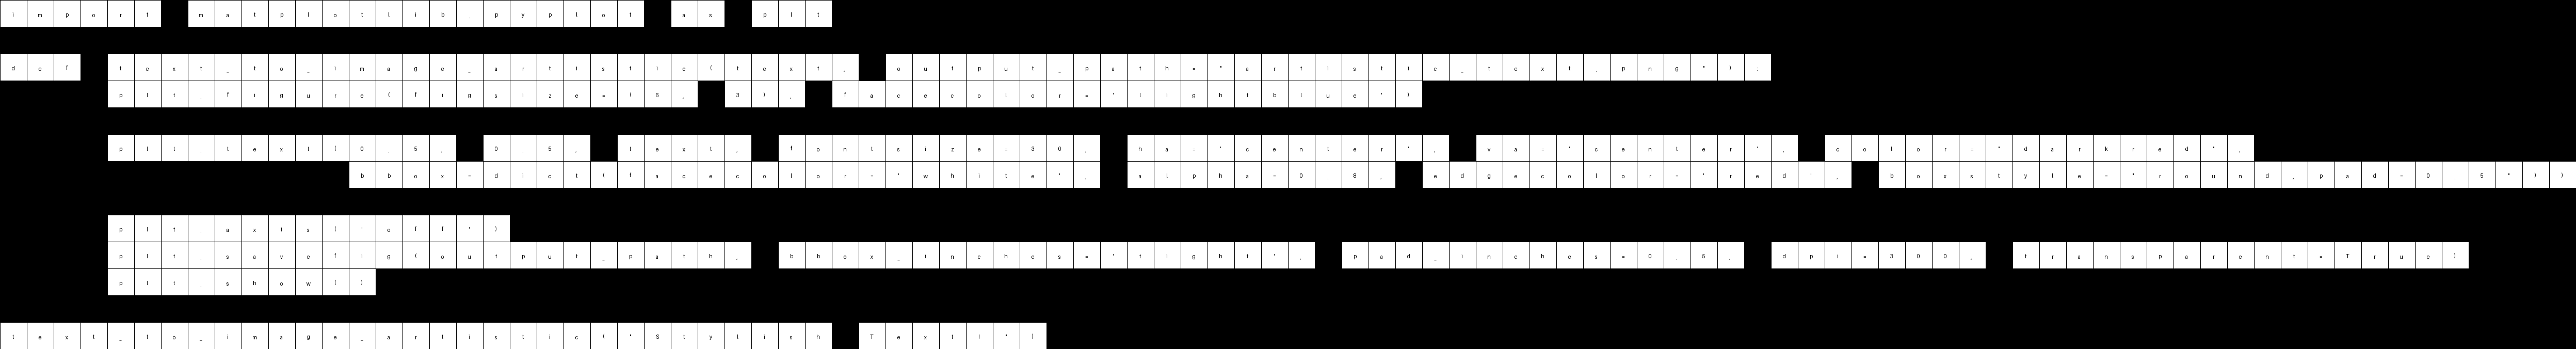

In [51]:
display(test_input)

数据计算